# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [66]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import pandas as pd
import sys

%matplotlib inline
from matplotlib import pyplot as plt

from injectio import pharma, fit, injectables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
t3_ec_cali = np.array([0.000000000, 0.246635358])
t2_ev_cali = np.array([0.000000000, 1.428689307])

calibrated_injectables = dict(injectables.injectables)
calibrated_injectables["ec"] = injectables.calibratedInjection(
    calibrated_injectables["ec"],
    t3_ec_cali)
calibrated_injectables["ev"] = injectables.calibratedInjection(
    calibrated_injectables["ev"],
    t2_ev_cali)

# Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

## Menstrual

In [110]:
def molarConcToMassConc(molar_conc, molar_weight):
    """Converts pmol/L to pg/mL for a substance of a particular molar weight.
    
    molar         Molar concentration in pmol/L [array like].
    molar_weight  Molar weight of substance in g/mol."""
    return molar_conc * molar_weight * 10**-3


e2_mol = 272.388 # g/mol

# Stricker2006, referenced from https://en.wikiversity.org/wiki/WikiJournal_of_Medicine/Reference_ranges_for_estradiol,_progesterone,_luteinizing_hormone_and_follicle-stimulating_hormone_during_the_menstrual_cycle
menstrual_e2 = molarConcToMassConc(np.array([118.42, 133.01, 133.17, 125.95, 134.65, 151.33, 159.48, 170.34, 195.9, 228.2, 269.07, 343.68, 477.27, 661.19, 914.84, 780.76, 320.59, 261.32, 338.94, 454.07, 499.49, 497.07, 531.14, 504.39, 499.18, 526.68, 350.65, 322.24, 229.7, 249.28]),
                                   e2_mol)

menstrual_fit_start_t = pd.to_datetime("2020")
menstrual_fit_range_t = 6*7 - 1 + len(menstrual_e2) # 6 weeks to steady state, then the menstrual curve.
menstrual_fit_t  = pd.date_range(pd.to_datetime("2020"),
                                 menstrual_fit_start_t + pd.to_timedelta(menstrual_fit_range_t, unit='D'),
                                 freq='1D')
menstrual_fit_e2 = np.append(np.full(6*7, menstrual_e2[0]), menstrual_e2)

menstrual_fit_results = fit.emptyResults()

### Estradiol Cypionate

Least squares figures out some real gymnastics to get this close, but EC doesn't decay quickly enough to mimic the big peak very well. I wonder if this result is still in range for some realistic cycle, even if it doesn't quite match the mean?

In [104]:
menstrual_fit_results["ec"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", menstrual_fit_range_t, '3D', start_date=menstrual_fit_start_t),
    calibrated_injectables,
    menstrual_fit_t, menstrual_fit_e2,
    max_dose=10.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    menstrual_fit_results["ec"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.4488e+04                                    1.04e+05    
       1              2         4.3451e+04      3.10e+04       2.33e+00       1.51e+04    
       2              3         2.1994e+04      2.15e+04       1.61e+00       4.87e+03    
       3              4         1.6606e+04      5.39e+03       1.44e+00       7.84e+03    
       4              5         1.6265e+04      3.41e+02       2.66e-01       2.53e+03    
       5              6         1.4373e+04      1.89e+03       1.38e+00       7.15e+03    
       6              7         1.4122e+04      2.52e+02       1.97e-01       3.00e+03    
       7              8         1.3853e+04      2.69e+02       3.06e-01       3.59e+03    
       8              9         1.3795e+04      5.73e+01       1.05e-01       5.59e+02    
       9             10         1.3368e+04      4.27e+02       4.31e-01       4.59e+03    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      2.051         ec
2020-01-03 20:47:34.311753600      0.187         ec
2020-01-07 00:59:13.324329600      0.267         ec
2020-01-10 00:46:02.908790399      0.543         ec
2020-01-12 23:01:57.911174400      0.447         ec
2020-01-15 23:29:23.476761600      0.379         ec
2020-01-18 23:43:52.093459200      0.363         ec
2020-01-22 00:29:15.959990399      0.387         ec
2020-01-25 00:13:09.760368000      0.448         ec
2020-01-27 23:39:20.090448000      0.455         ec
2020-01-30 23:44:25.229328000      0.427         ec
2020-02-03 00:23:00.505680000      0.445         ec
2020-02-06 00:06:38.788272000      0.480         ec
2020-02-08 23:57:20.441404800      0.469         ec
2020-02-11 22:41:55.503024000      0.373         ec
2020-02-15 12:51:56.183961600      1.205         ec
2020-02-18 08:17:36.112185600      1.801         ec
2020-02-21 12:02:46.495219200      4.535 

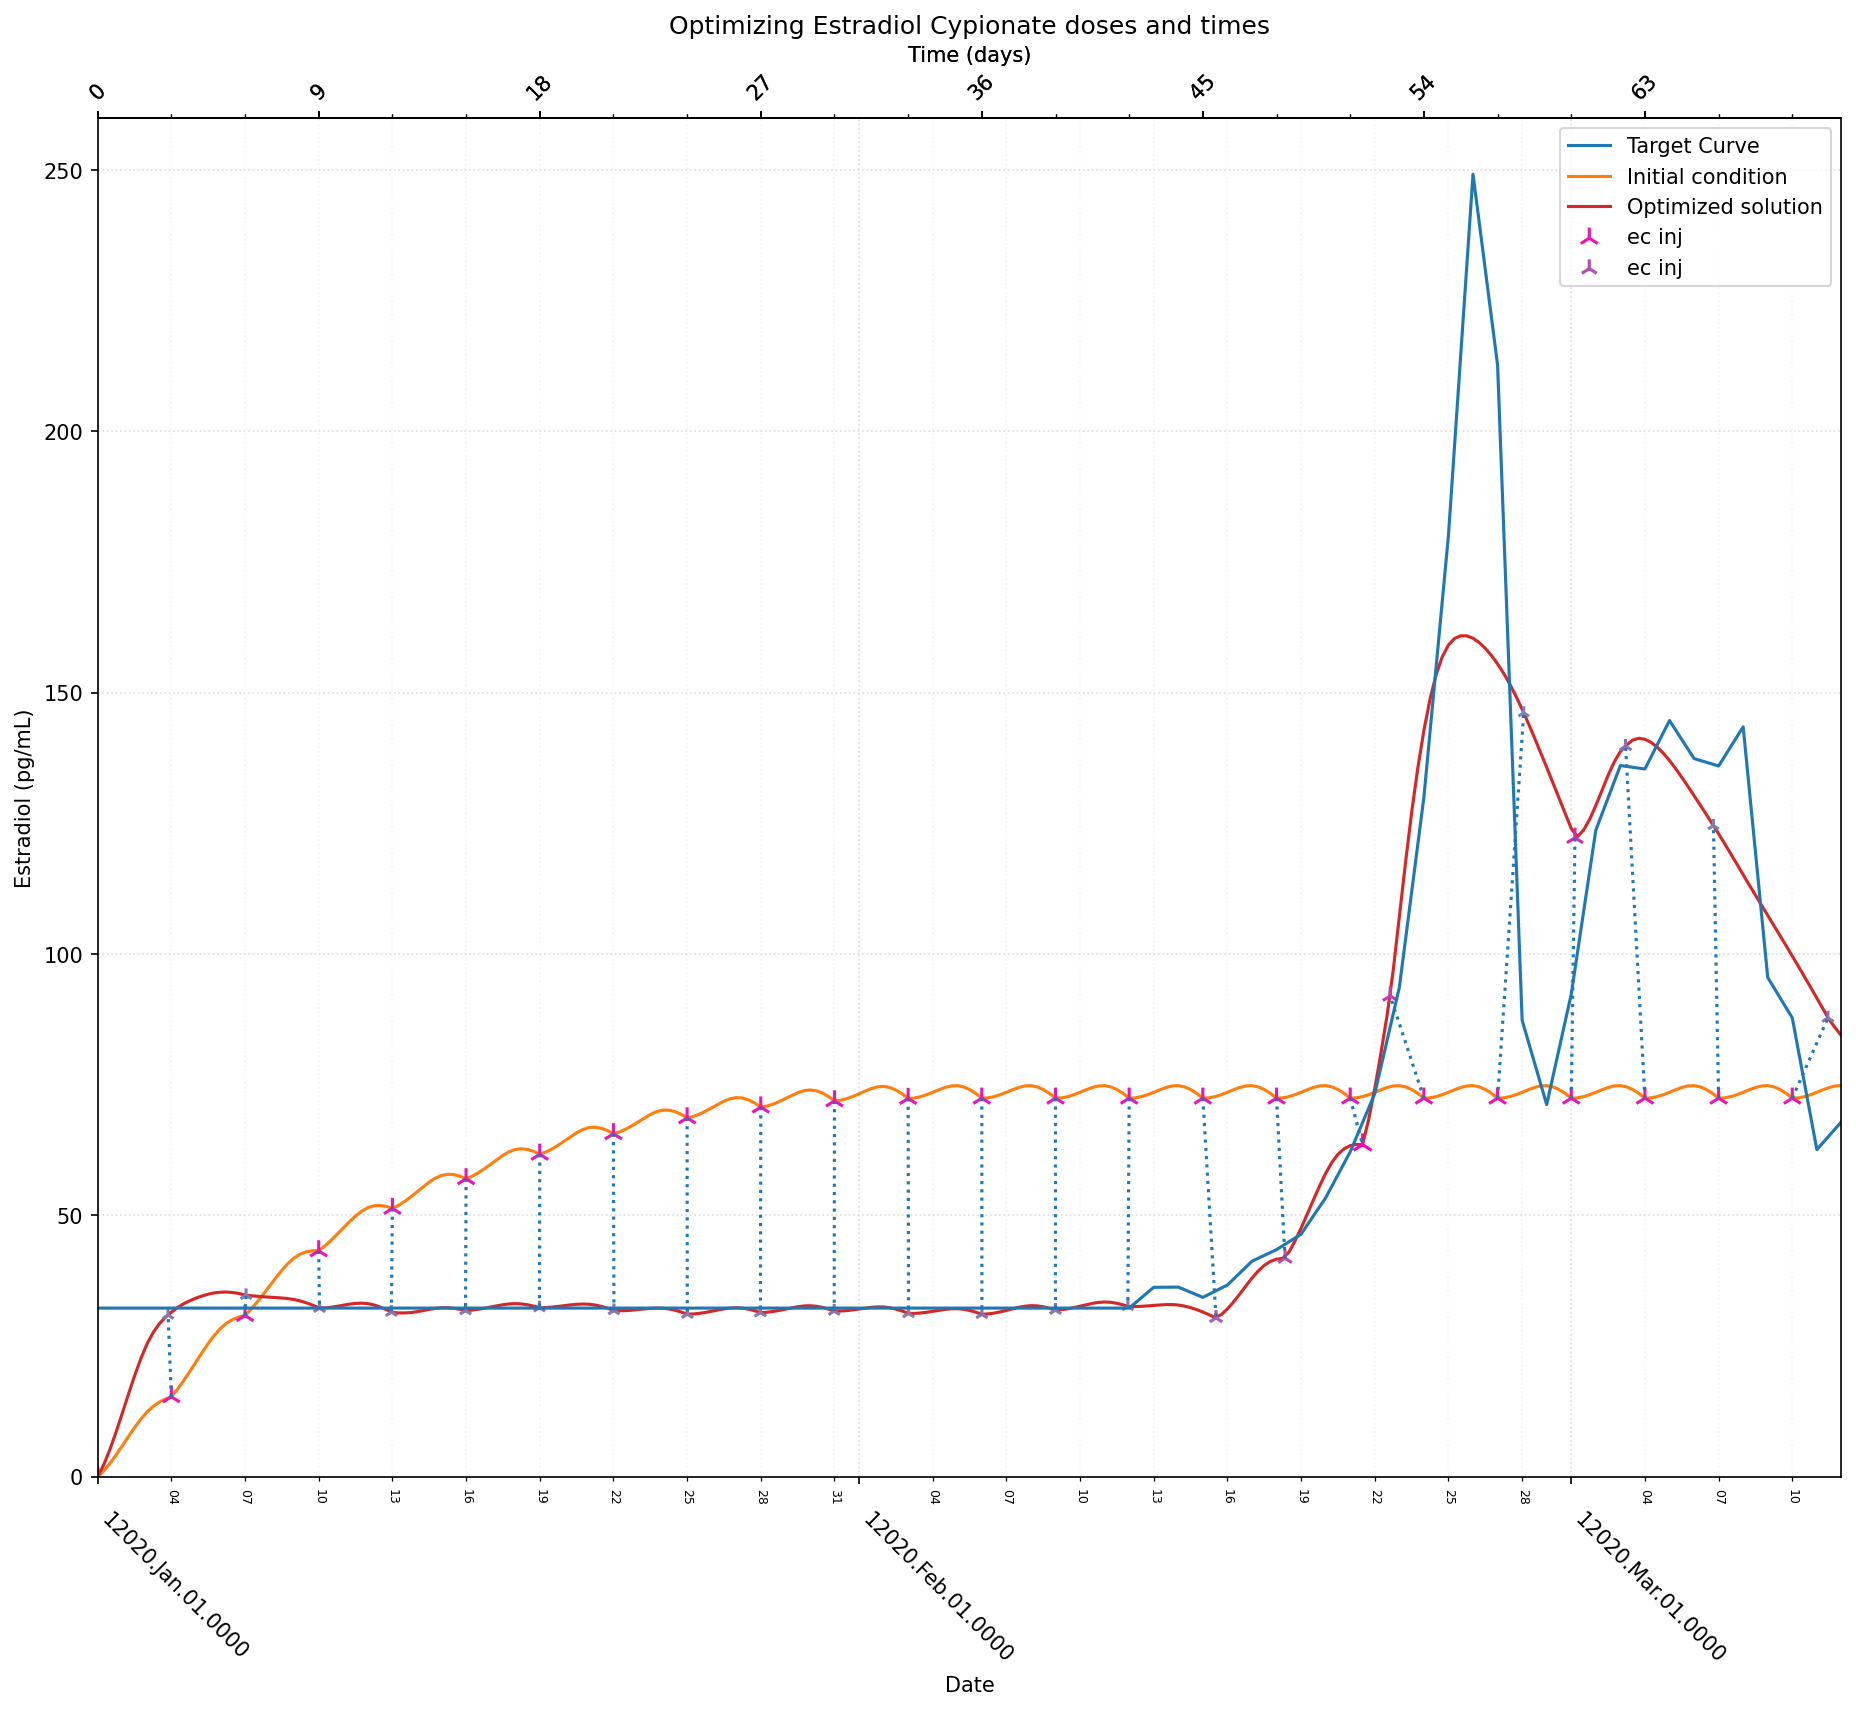

In [106]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ec"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", menstrual_fit_results["ec"]["injections_optim"])

### Estradiol Valerate

After all this work, it looks like EV can actually fit a realistic menstrual curve better than EC can. Wow! That's incredibly unexpected for me but I guess I was doing all of the curve fitting stuff at unrealistic time scales. The interesting bit here is that, because of the big intense spike in estradiol prior to ovulation, the decay rate of EC isn't able to keep up. EV, with it's big quick peak, and fast decay, is perfectly suited to mimicing that peak in estradiol.

Somatically it's almost like taking EV is like ovulating with every injection–and that actually resonates with my subjective experience pretty well. EV has a kind of dynamicism and responsiveness and punchiness to it. EC is much softer, pillowy, flowy, floaty. EV is unsurprisingly well suited to fitting to quicker, more dynamic curves; EC is better suited to gentler, more stable curves. They each have strengths. I have no idea how you'd get it prescribed, but I wonder if mixing medicines could work. Like using EC for most injections, but using EV for just around the big peak. Or maybe spiking with pills there. Once you've figured out the calibration for your body, a whole lot of magic is possible!

At realistic time scales there's a lot more to "stable levels" than just optimizing for constant e2 levels, that's for sure! I feel a bit sad and disappointed, and I wish I had done this piece with a real menstrual cycle curve much sooner. I am feeling a big expansion in my understanding of all this though, and how it fits together somatically. It's not what I was expecting, and that's really exciting! Laying it all out on a timeline is really important. I feel some inklings and sparking connections happening...

In [102]:
menstrual_fit_results["ev"] = fit.initializeRun(
    pharma.createInjectionsCycle("ev", menstrual_fit_range_t, '3D', start_date=menstrual_fit_start_t),
    calibrated_injectables,
    menstrual_fit_t, menstrual_fit_e2,
    max_dose=10.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    menstrual_fit_results["ev"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0074e+06                                    1.30e+05    
       1              2         2.1501e+05      7.92e+05       2.05e+00       3.66e+04    
       2              3         4.2536e+04      1.72e+05       1.06e+00       1.10e+05    
       3              4         3.2566e+04      9.97e+03       4.85e-01       2.76e+04    
       4              5         1.2719e+04      1.98e+04       4.69e-01       9.49e+04    
       5              6         1.1383e+04      1.34e+03       1.55e-01       5.01e+03    
       6              7         5.3731e+03      6.01e+03       2.95e-01       4.03e+04    
       7              8         5.1212e+03      2.52e+02       6.52e-02       2.86e+03    
       8              9         4.6489e+03      4.72e+02       1.56e-01       5.71e+03    
       9             10         4.3563e+03      2.93e+02       8.06e-02       1.57e+04    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      0.221         ev
2020-01-04 03:18:56.027635200      0.140         ev
2020-01-07 02:14:17.193379200      0.141         ev
2020-01-10 02:27:01.581004800      0.141         ev
2020-01-13 02:26:49.001078400      0.142         ev
2020-01-16 02:26:22.764163200      0.142         ev
2020-01-19 02:26:06.918144000      0.142         ev
2020-01-22 02:26:16.627257600      0.142         ev
2020-01-25 02:26:16.640908800      0.142         ev
2020-01-28 02:26:14.162783999      0.142         ev
2020-01-31 02:26:09.315571200      0.142         ev
2020-02-03 02:27:13.925232000      0.142         ev
2020-02-06 02:21:31.672368000      0.142         ev
2020-02-09 02:40:14.209075200      0.144         ev
2020-02-12 01:28:22.428825600      0.163         ev
2020-02-15 05:02:02.683651200      0.202         ev
2020-02-18 08:37:14.002348800      0.284         ev
2020-02-21 12:05:47.523609600      0.574 

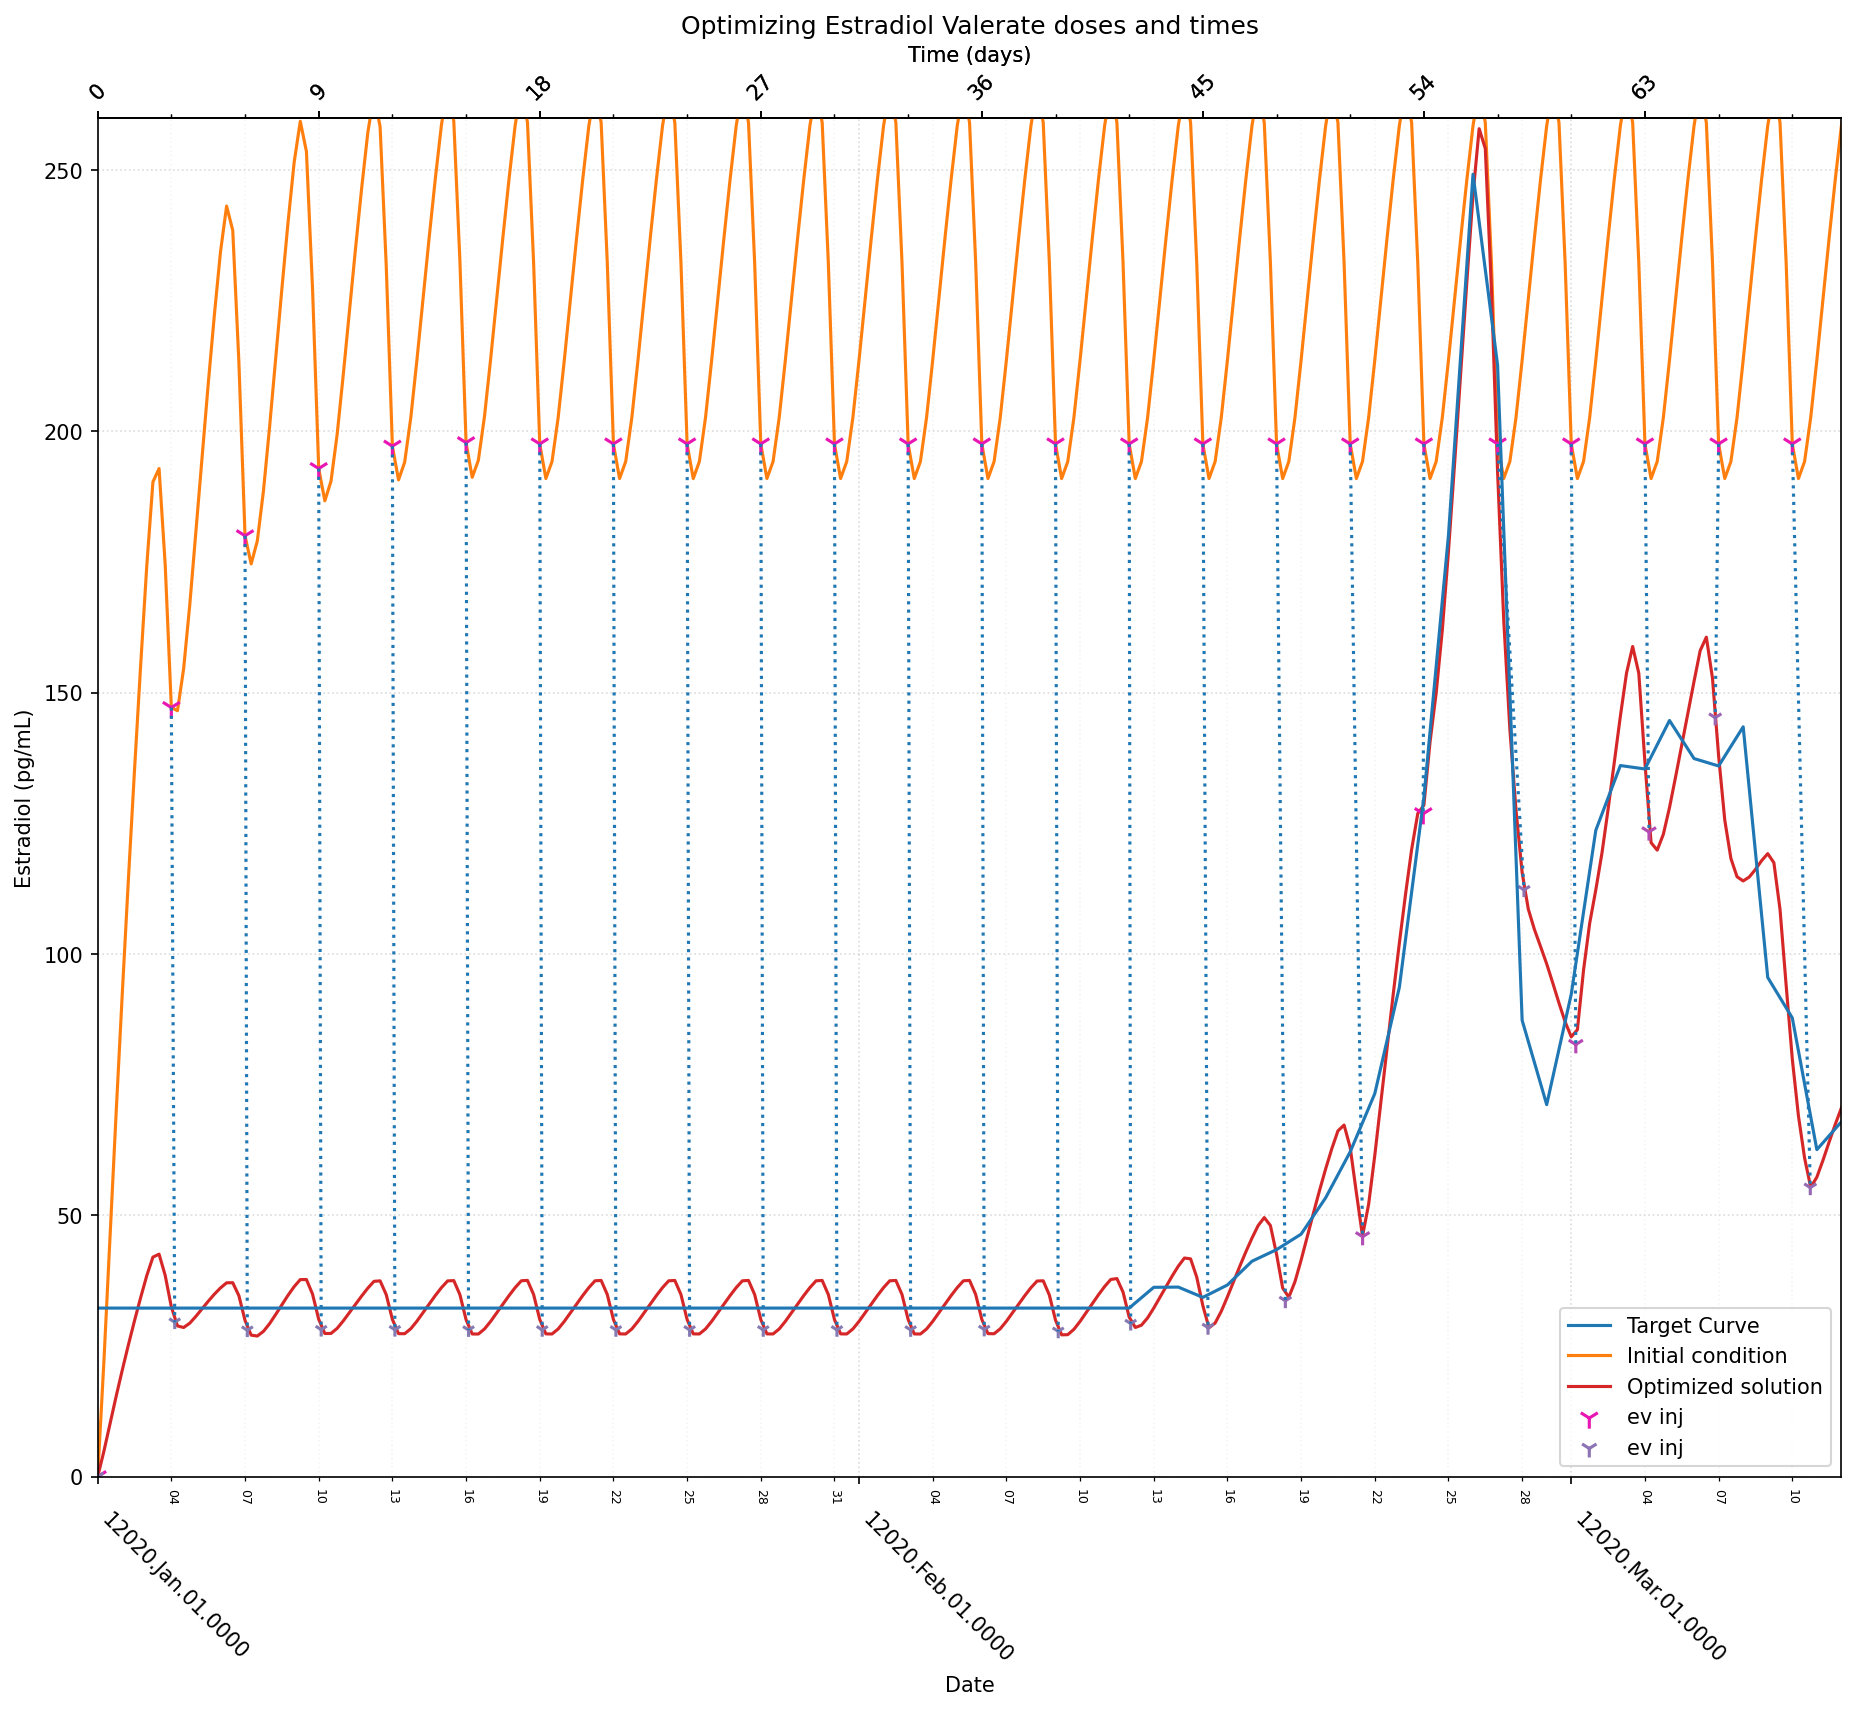

In [108]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ev"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", menstrual_fit_results["ev"]["injections_optim"])

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [69]:
cycling_start_t = 42.0 # days
sine_target_func = lambda T: int(T>=cycling_start_t) * (250.0 + 50.0*np.sin((2*math.pi/30)*(T-cycling_start_t))) +\
                             int(T<cycling_start_t)  * (250.0)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(90.0, unit='D'), freq='18H')
sine_target_y = np.array([sine_target_func(pharma.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

sine_results = fit.emptyResults()

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [77]:
sine_results["ec_doses"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 90.0, '3D', start_date="2020"),
    calibrated_injectables,
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='fixed')
fit.runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         5.5495e+05      1.65e+06       8.46e+00       8.44e+04    
       2              3         2.3290e+05      3.22e+05       4.14e+00       2.35e+04    
       3              4         1.7248e+05      6.04e+04       1.90e+00       1.29e+04    
       4              5         1.5692e+05      1.56e+04       1.40e+00       4.62e+03    
       5              6         1.5177e+05      5.14e+03       6.34e-01       4.77e+03    
       6              7         1.4992e+05      1.85e+03       5.28e-01       1.99e+03    
       7              8         1.4822e+05      1.70e+03       3.64e-01       2.82e+03    
       8              9         1.4759e+05      6.28e+02       3.03e-01       1.30e+03    
       9             10         1.4686e+05      7.34e+02       2.28e-01       1.81e+03    

Optimized Injections:
                  dose injectable
2020-01-01      5.000         ec
2020-01-04      5.000         ec
2020-01-07      4.987         ec
2020-01-10      4.348         ec
2020-01-13      3.228         ec
2020-01-16      3.228         ec
2020-01-19      3.191         ec
2020-01-22      3.095         ec
2020-01-25      3.138         ec
2020-01-28      3.330         ec
2020-01-31      3.454         ec
2020-02-03      3.391         ec
2020-02-06      3.372         ec
2020-02-09      3.980         ec
2020-02-12      4.646         ec
2020-02-15      4.601         ec
2020-02-18      4.054         ec
2020-02-21      2.940         ec
2020-02-24      2.172         ec
2020-02-27      1.880         ec
2020-03-01      2.034         ec
2020-03-04      2.738         ec
2020-03-07      4.003         ec
2020-03-10      4.652         ec
2020-03-13      4.802         ec
2020-03-16      4.707         ec
2020-03-19      4.206         ec
2020-03-22      2.929         ec
2020-03-25      2.12

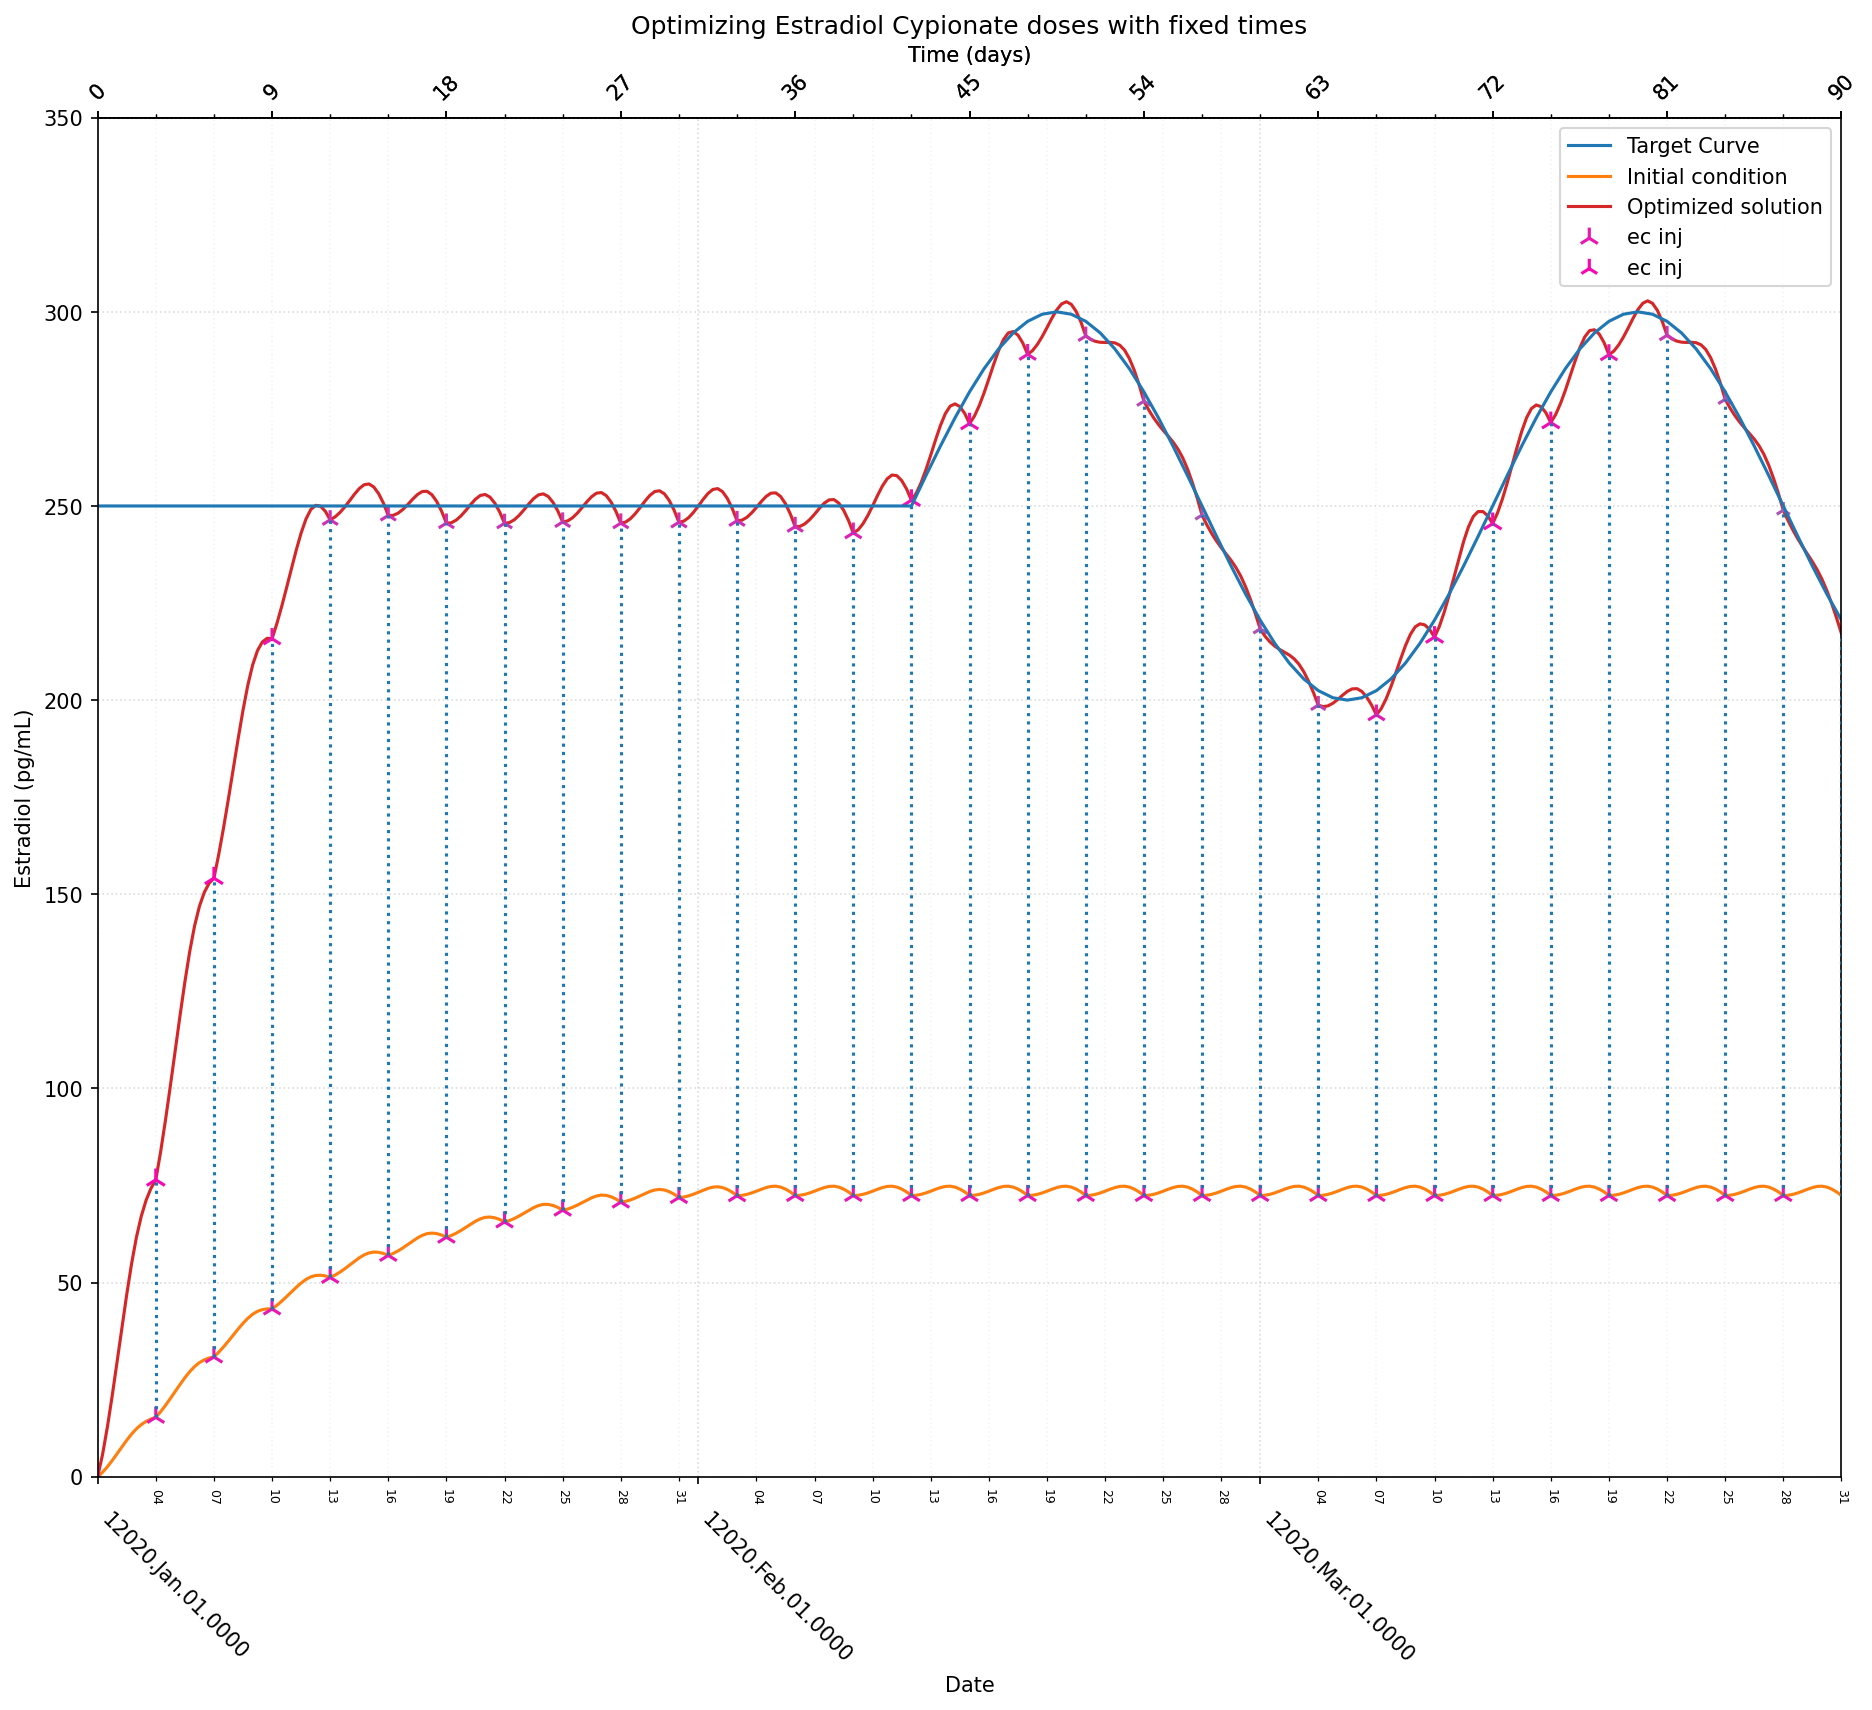

In [78]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses with fixed times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses"]["injections_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [74]:
sine_results["ec_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 90.0, '3D', start_date="2020"),
    calibrated_injectables,
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    sine_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=30,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2027e+06                                    2.45e+05    
       1              2         5.5419e+05      1.65e+06       8.46e+00       8.44e+04    
       2              3         2.2691e+05      3.27e+05       4.17e+00       2.30e+04    
       3              4         1.5469e+05      7.22e+04       2.13e+00       1.21e+04    
       4              5         1.3343e+05      2.13e+04       1.54e+00       5.32e+03    
       5              6         1.2451e+05      8.92e+03       8.02e-01       4.81e+03    
       6              7         1.2131e+05      3.20e+03       5.55e-01       2.74e+03    
       7              8         1.1819e+05      3.12e+03       4.84e-01       3.38e+03    
       8              9         1.1735e+05      8.39e+02       2.86e-01       1.51e+03    
       9             10         1.1600e+05      1.35e+03       2.65e-01       2.00e+03    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      5.000         ec
2020-01-02 12:00:00.000000000      5.000         ec
2020-01-05 12:00:52.451452800      4.982         ec
2020-01-08 19:14:32.319744000      4.467         ec
2020-01-12 11:03:48.710966400      3.982         ec
2020-01-15 16:42:10.564185600      3.465         ec
2020-01-18 21:44:11.372784000      3.244         ec
2020-01-22 02:17:31.102108800      3.210         ec
2020-01-25 03:22:38.130931200      3.260         ec
2020-01-28 03:49:45.381878400      3.358         ec
2020-01-31 03:15:52.183123200      3.457         ec
2020-02-03 03:10:33.267331200      3.518         ec
2020-02-06 04:39:24.615705600      3.592         ec
2020-02-09 10:30:31.464374400      3.814         ec
2020-02-12 04:06:22.935974400      4.267         ec
2020-02-14 15:53:22.848691200      4.183         ec
2020-02-17 11:14:45.472876800      3.848         ec
2020-02-20 11:11:13.650144000      3.211 

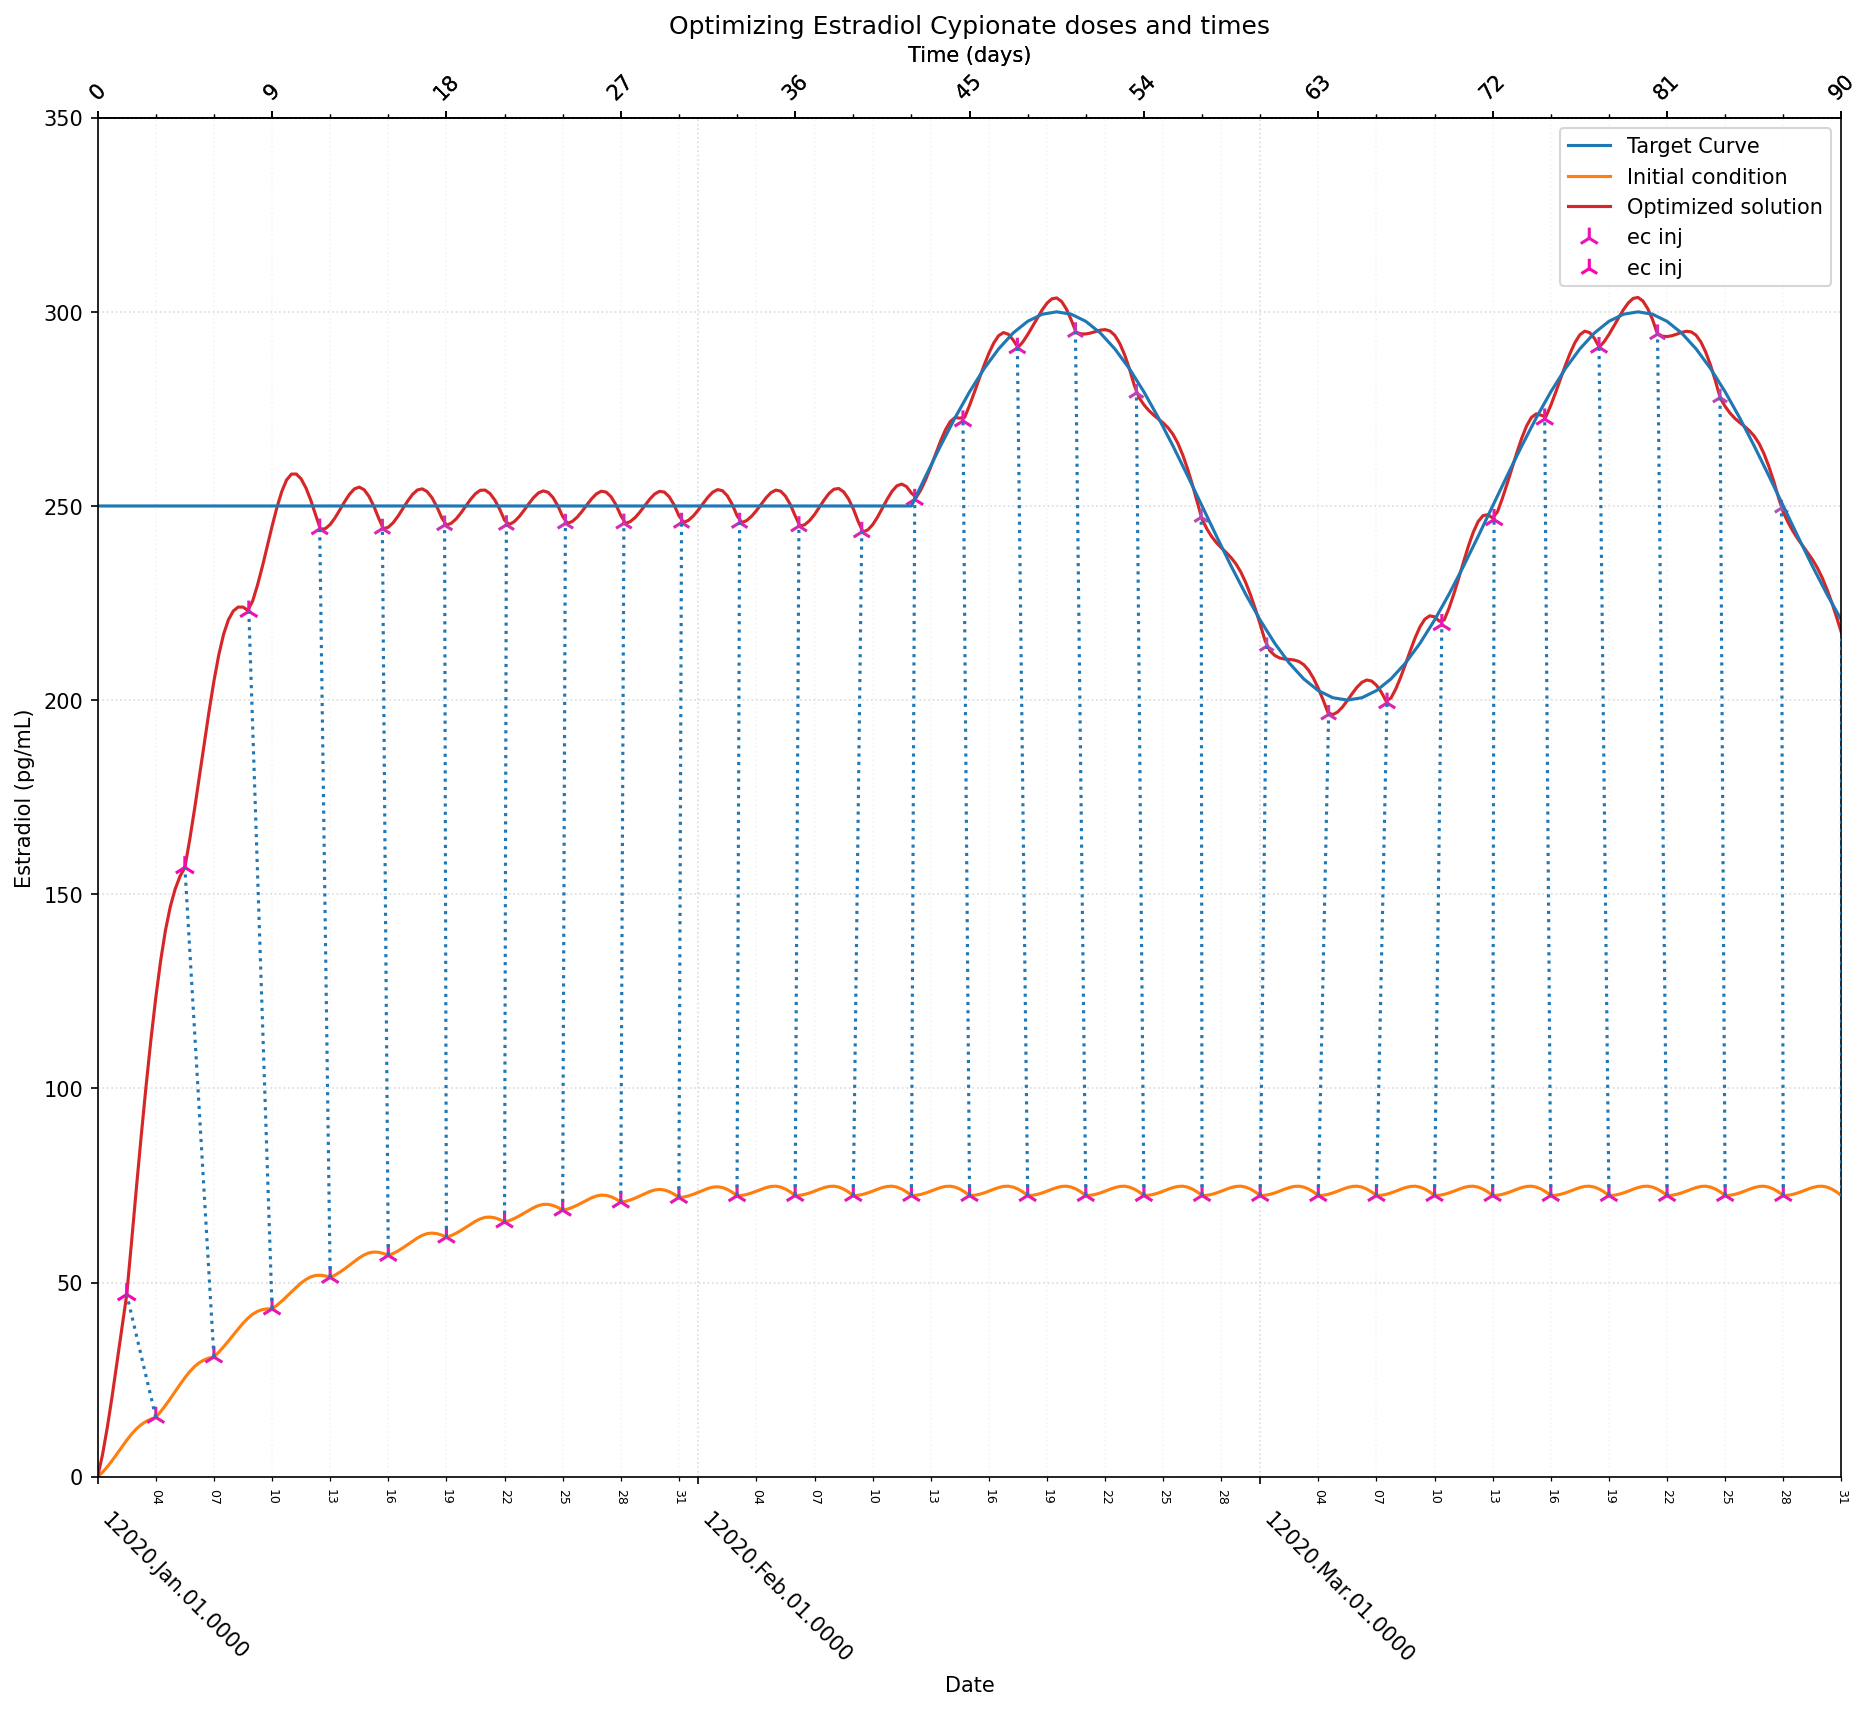

In [75]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", sine_results["ec_doses_and_times"]["injections_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV just really doesn't work for doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [79]:
sine_results["ev_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ev", 90.0, '3D', start_date="2020"),
    calibrated_injectables,
    sine_target_x, sine_target_y,
    max_dose=5.0,
    time_bounds='midpoints')
fit.runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9672e+05                                    2.87e+05    
       1              2         1.0469e+05      9.20e+04       9.42e-01       9.26e+04    
       2              3         9.5611e+04      9.08e+03       3.98e-01       1.50e+04    
       3              4         8.9341e+04      6.27e+03       3.55e-01       3.37e+04    
       4              5         8.7754e+04      1.59e+03       1.38e-01       6.05e+03    
       5              6         8.3778e+04      3.98e+03       3.67e-01       1.87e+04    
       6              7         8.2975e+04      8.04e+02       9.11e-02       5.25e+03    
       7              8         8.1413e+04      1.56e+03       2.63e-01       8.70e+03    
       8              9         8.1225e+04      1.88e+02       4.48e-02       4.11e+03    
       9             10         8.0982e+04      2.43e+02       9.42e-02       5.50e+03    

Optimized Injections:
                                     dose injectable
2020-01-01 00:00:00.000000000      1.710         ev
2020-01-04 06:58:19.265404800      1.100         ev
2020-01-07 05:21:38.916403200      1.068         ev
2020-01-10 05:26:14.491881600      1.085         ev
2020-01-13 05:38:21.538982400      1.086         ev
2020-01-16 05:33:28.733875200      1.089         ev
2020-01-19 05:32:24.438537600      1.088         ev
2020-01-22 05:32:54.824294400      1.088         ev
2020-01-25 05:33:06.765292800      1.088         ev
2020-01-28 05:33:02.918678400      1.088         ev
2020-01-31 05:33:02.143843200      1.088         ev
2020-02-03 05:32:57.381043200      1.088         ev
2020-02-06 05:33:27.952646400      1.089         ev
2020-02-09 05:42:11.901513600      1.093         ev
2020-02-12 06:21:14.929459200      1.245         ev
2020-02-15 05:47:44.025446400      1.318         ev
2020-02-18 05:09:09.808531200      1.302         ev
2020-02-21 04:39:36.948355200      1.202 

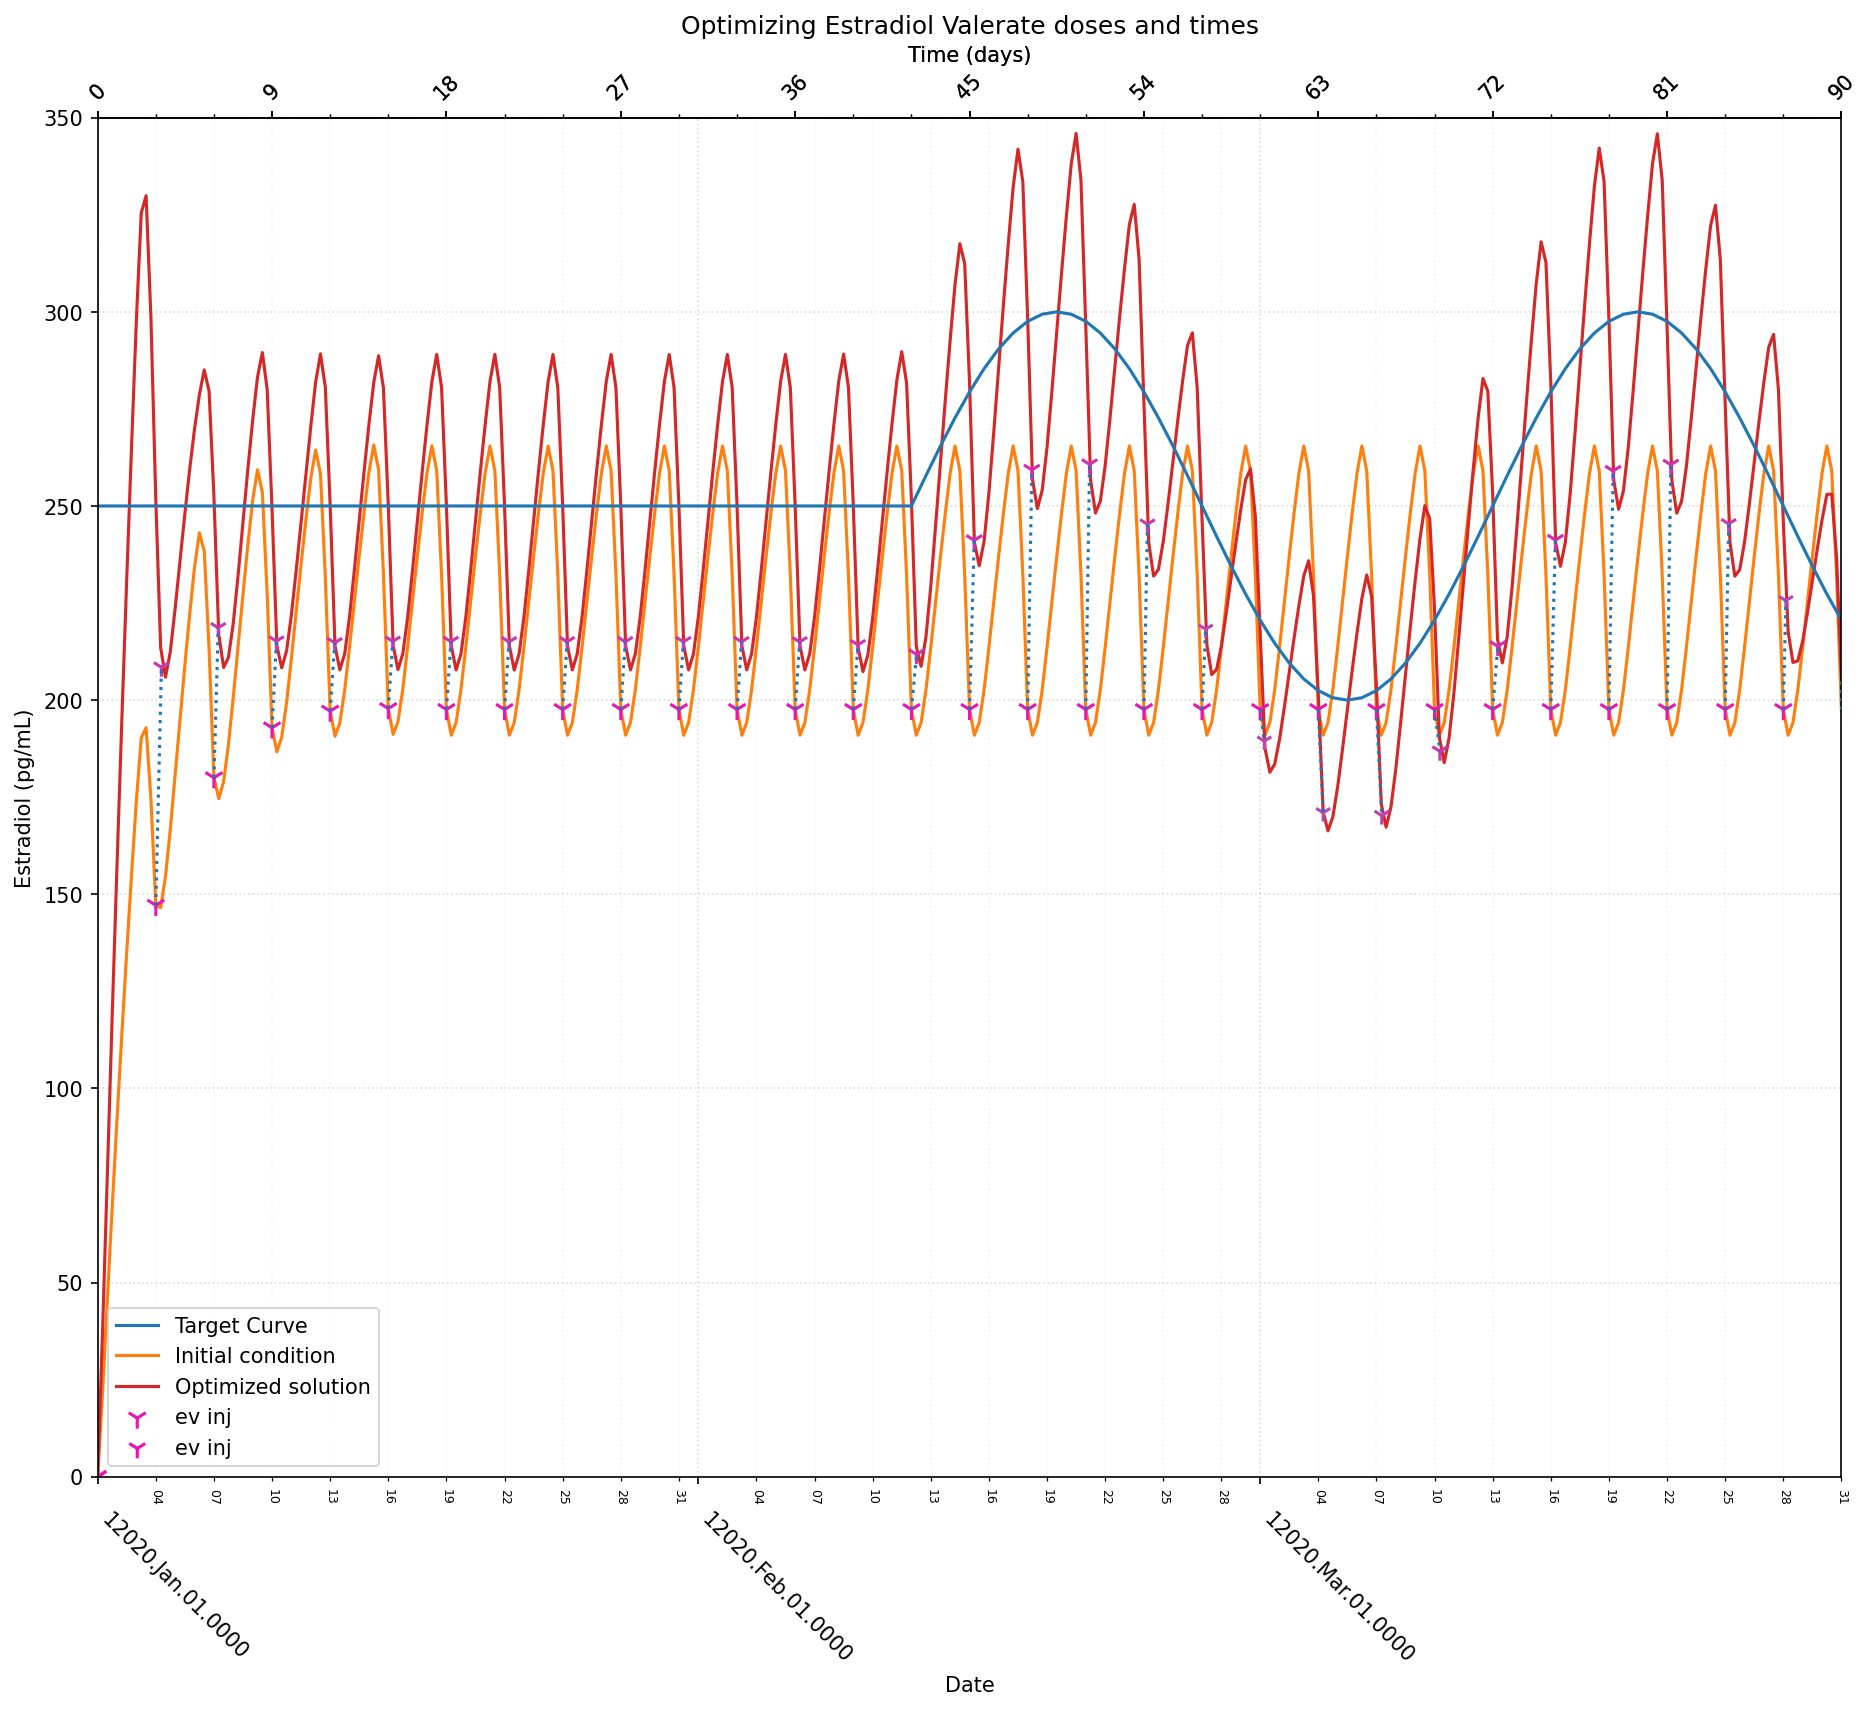

In [80]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Injections:\n", sine_results["ev_doses_and_times"]["injections_optim"])

### Step func (Estradiol Cypionate, optimize doses & times)

It's fun! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [86]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='6H')
step_target_y = np.array([step_func(T) for T in step_target_x])

In [87]:
step_results = fit.emptyResults()

In [88]:
step_results["ec_doses_and_times"] = fit.initializeRun(
    pharma.createInjectionsCycle("ec", 62.0, '3D'),
    calibrated_injectables,
    step_target_x, step_target_y,
    max_dose=1.5,
    time_bounds='midpoints')
fit.runLeastSquares(
    step_results["ec_doses_and_times"],
    xtol=None,
    max_nfev=35,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3324e+06                                    5.22e+05    
       1              2         2.8834e+05      1.04e+06       1.10e+00       1.20e+05    
       2              3         1.3298e+05      1.55e+05       5.00e-01       5.47e+04    
       3              4         8.4492e+04      4.85e+04       4.35e-01       3.37e+04    
       4              5         7.4254e+04      1.02e+04       2.10e-01       1.92e+04    
       5              6         6.7087e+04      7.17e+03       1.63e-01       1.67e+04    
       6              7         6.3290e+04      3.80e+03       1.23e-01       1.22e+04    
       7              8         5.9641e+04      3.65e+03       1.26e-01       1.43e+04    
       8              9         5.7430e+04      2.21e+03       9.08e-02       9.80e+03    
       9             10         5.5026e+04      2.40e+03       1.13e-01       1.27e+04    

Optimized Injections:
                                     dose injectable
1970-01-01 00:00:00.000000000      1.485         ec
1970-01-03 17:51:52.166073600      0.145         ec
1970-01-07 01:23:45.262809600      0.234         ec
1970-01-10 00:27:22.556361599      0.413         ec
1970-01-12 22:09:44.779161600      0.344         ec
1970-01-16 00:20:13.740979200      0.285         ec
1970-01-18 23:19:25.568112000      0.293         ec
1970-01-22 02:03:59.275007999      0.303         ec
1970-01-25 03:34:15.658262400      0.328         ec
1970-01-29 05:51:57.445545600      1.244         ec
1970-01-30 19:06:50.827881600      1.492         ec
1970-02-02 10:20:51.811612800      0.723         ec
1970-02-06 02:21:11.551363200      0.817         ec
1970-02-08 23:18:24.669763200      0.936         ec
1970-02-11 21:24:28.618905600      0.813         ec
1970-02-15 00:01:31.651392000      0.755         ec
1970-02-18 00:11:20.145292799      0.800         ec
1970-02-21 01:04:19.968902400      0.828 

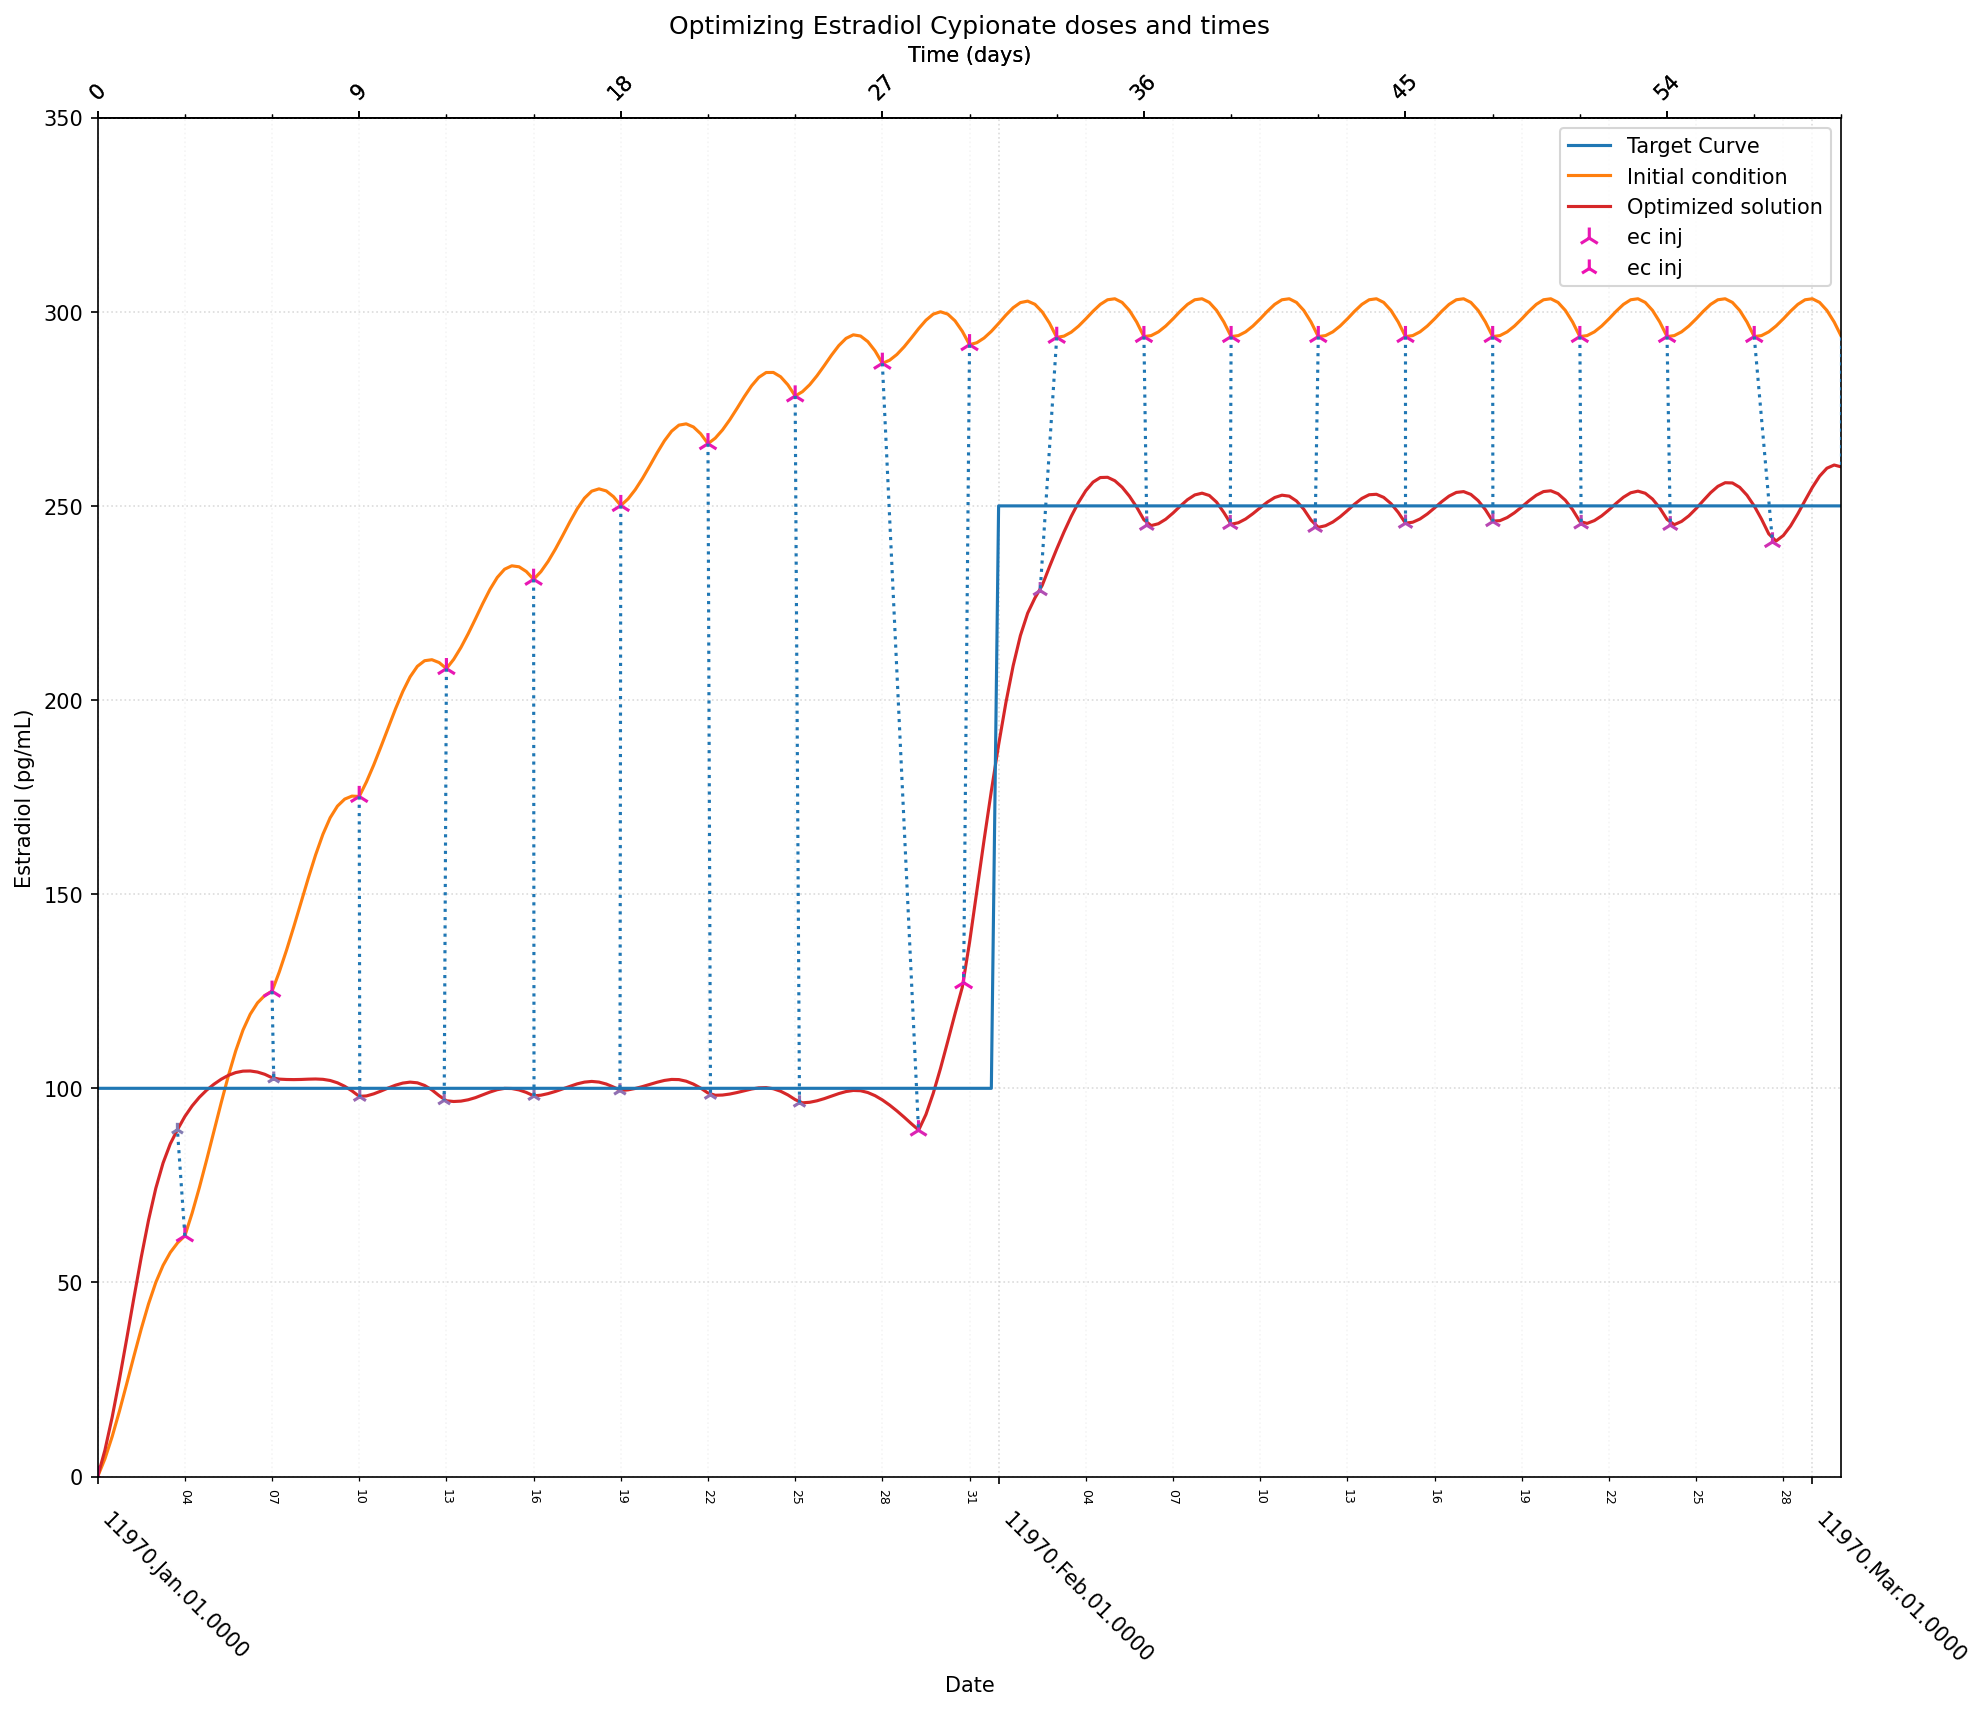

In [89]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Injections:\n", step_results["ec_doses_and_times"]["injections_optim"])